In [95]:
from qiskit import QuantumCircuit, Aer, execute, transpile, execute, IBMQ
from qiskit_aer import AerSimulator

from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import RGQFTMultiplier

from qiskit.circuit import Instruction, CircuitInstruction, Qubit, QuantumRegister, Clbit, ClassicalRegister
from qiskit.circuit.library.standard_gates import IGate, XGate, CXGate, CCXGate, C3XGate, C4XGate, MCXGate
from qiskit.exceptions import QiskitError

import matplotlib.pyplot as plt
%matplotlib inline
from qiskit.visualization import plot_histogram

import os
import sys
import math as m
import numpy as np
import pandas as pd
import sympy

from _functools import *
from traceback import format_exc

In [96]:
backend = AerSimulator(method='matrix_product_state')

Inspired by: https://quantumcomputinguk.org/tutorials/multiplication-on-quantum-computers-with-qiskit

# Step 1: Initialize the registers and quantum circuit
The first step is to initialise the registers and quantum circuit. Our circuit will consist of two registers. A quantum register that holds our qubits and a classical register that holds the bits used to measure the output qubits. 

For our quantum register we will have 8 qubits:

Qubits 0 and 1 hold Operand A which we will use to store 2. 

Qubits 2 and 3 hold Operand B which we will use to store 3.

Qubits 4 to 7 hold the output qubits that will hold the result. 

The classical register will hold the result when we measure the output qubits and as such will have 4 bits. 

In Qiskit the registers can circuit can be initialized using the following code:

In [97]:
inputDigits = 3

In [98]:
nInputs = inputDigits + inputDigits
nOutput = 2*inputDigits

nQubits = nInputs+nOutput

q = QuantumRegister(nQubits,'q')
c = ClassicalRegister(nOutput,'c')

mCirc = QuantumCircuit(q, c)

In [99]:
mCirc.data = [CircuitInstruction(operation=Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
                                 qubits=(Qubit(q, inputIndex),),
                                 clbits=()) for inputIndex in range(nInputs)]

In [100]:
list(mCirc.data)

[CircuitInstruction(operation=Instruction(name='id', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 0),), clbits=()),
 CircuitInstruction(operation=Instruction(name='id', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 1),), clbits=()),
 CircuitInstruction(operation=Instruction(name='id', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 2),), clbits=()),
 CircuitInstruction(operation=Instruction(name='id', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 3),), clbits=()),
 CircuitInstruction(operation=Instruction(name='id', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 4),), clbits=()),
 CircuitInstruction(operation=Instruction(name='id', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 5),), clbits=())]

# Step 2: Encode the values on to the Operands
The next step is to encode 2 on to Operand A and 3 on to Operand B. 

Since 2 is ‘10’ in binary we leave qubit 0 as is so that its state is |0〉and apply a Pauli-X gate to qubit 1 so that it state flips from |0〉 to |1〉. 

To encode 3 on Operand B we apply Pauli-X gates to qubits 2 and 3 since 3 is ‘11’ in binary. 

The encodings are done with the following code: 

In [101]:
A, B = 7, 6

ABin, BBin = bin(A)[2:], bin(B)[2:]

# Operand A
for ADigit, AIndex in zip(ABin, range(len(ABin))[::-1]):
    ABinInput = int(ADigit)
    gateName = ['id', 'x'][ABinInput]
    
    mCirc.data[AIndex].operation.name = gateName
    
    print(AIndex, ADigit, gateName)

# Operand B
for BDigit, BIndex in zip(BBin, range(len(BBin))[::-1]):
    BBinInput = int(BDigit)
    gateName = ['id', 'x'][BBinInput]
    
    mCirc.data[BIndex+inputDigits].operation.name = gateName
    
    print(BIndex+inputDigits, BDigit, gateName)

2 1 x
1 1 x
0 1 x
5 1 x
4 1 x
3 0 id


In [102]:
list(mCirc.data)

[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 0),), clbits=()),
 CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 1),), clbits=()),
 CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 2),), clbits=()),
 CircuitInstruction(operation=Instruction(name='id', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 3),), clbits=()),
 CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 4),), clbits=()),
 CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(12, 'q'), 5),), clbits=())]

# Step 3: Create the QFT multiplication circuit
The next step is to create the QFT multiplication circuit. Thankfully this is incredibly simple as the circuit has a dedicated class in Qiskit and as such can be added using 2 lines of code: 

In [103]:
mCirc1 = RGQFTMultiplier(num_state_qubits=inputDigits,
                         num_result_qubits=inputDigits*2)

mCirc = mCirc.compose(mCirc1)

The first line creates the multiplier circuit using the RGQFTMultiplier() function which we pass the following arguments in to:

num_state_qubits: The number of bits for each operand. Since we are doing 2*3 we only need 2 bits for each 

num_result_qubits: This denotes the number of output qubits. For this we set it to 4 to prevent integer overflow. 

The second line simply add the multiplier circuit (which we have denoted as circuit1) to our main circuit using the circuit.compose() method.

# Step 4: Measure the output qubits
The next part is to measure the output qubits using the following code:

In [104]:
rangeLimit = 2**inputDigits

# Qubit Range
QRange = range(nInputs, nQubits)

# Classical Bit Range
CRange = range(0, nOutput)

mCirc.measure(QRange, CRange)

# Step 5: Send the circuit to a backend device and get the results back
The final step is to send the circuit off to be run on a backend device and get the results and print them. 

Note: Since this is only a tutorial we will be using a backend quantum simulator since it is much quicker. However you can set the backend device to be any real quantum device you have access to.

In [105]:
job = execute(mCirc, backend, shots=2000)
result = job.result()
counts = result.get_counts()
print(f'{A}*{B}')
print('---')
print(counts)
print(int(list(counts)[0], 2))

7*6
---
{'101010': 2000}
42


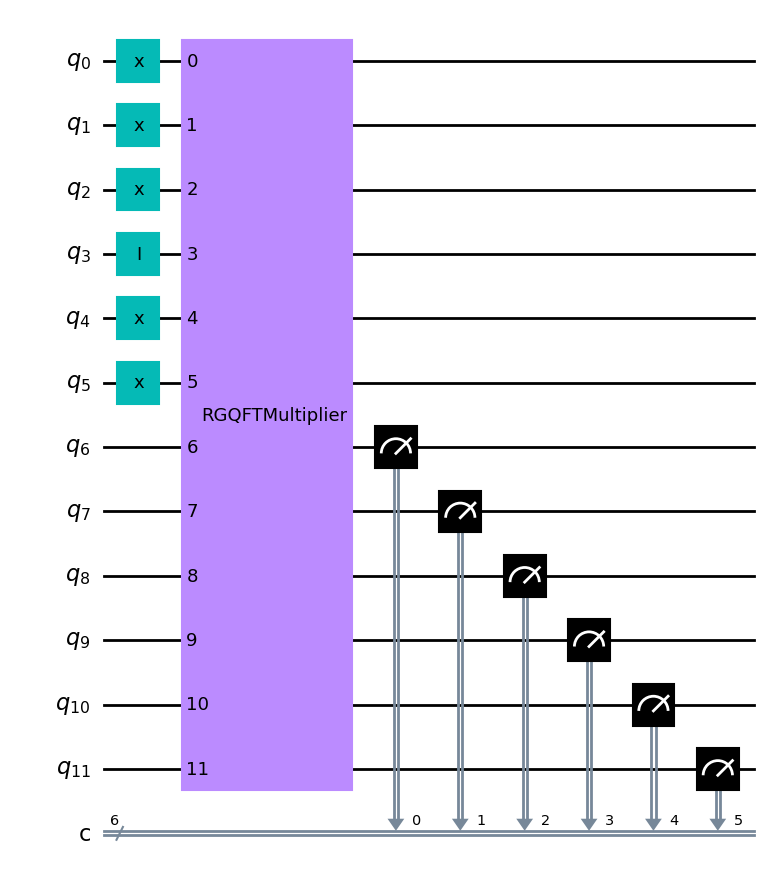

In [106]:
mCirc.draw(output='mpl')